# CBIR WITH COLOR HISTOGRAM

In [1]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import random
import os

## We store the paths of all images

In [2]:
n_imgs = 100
folders = ["bus-n04487081", "nails-n03804744", "car-n02814533", "collar-n03814639", "plunger-n03970156",
           "cats-n02123394", "monkey-n02480495", "bridges-n04532670", "chair-n04099969", "dog-n02099601",
           "duck-n01855672", "pizza-n07873807", "sea-n09428293", "ipod-n03584254", "banana-n07753592", "gas_mask-n03424325",
           "bow_tie-n02883205", "fly-n02190166", "ice_cream-n07615774", "cannon-n02950826"]
len(folders)


20

In [3]:
def get_images_path(folders, n_imgs):
    images_path = {}
    for folder in folders:
        for i in range(n_imgs):
            images_path[(folder[-7:], str(i))] = f'../dataset/{folder}/{folder[-9:]}_{str(i)}.JPEG'
    return images_path  # Returns a dictionary where the key is (folder, id), and the values are the paths


In [4]:
images_path = get_images_path(folders, n_imgs)
len(images_path)

2000

## We see how to obtain the color histogram of an image

In [5]:
# Function to calculate the color histogram of an image
def calculate_color_histogram(image, bins=8):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    histograms = []
    for i in range(3):
        hist = cv2.calcHist([rgb_image], [i], None, [bins], [0, 256])
        histograms.append(hist)
    histogram = np.concatenate(histograms)
    histogram = cv2.normalize(histogram, None).flatten()
    return histogram

In [6]:
histogram_1 = calculate_color_histogram(cv2.imread(list(images_path.values())[0]))
histogram_1

array([0.25785977, 0.17695625, 0.23046215, 0.33973023, 0.20403153,
       0.06736586, 0.0235297 , 0.02030645, 0.11120202, 0.17824556,
       0.31491122, 0.3706734 , 0.20983337, 0.08670534, 0.02385203,
       0.024819  , 0.10120995, 0.17308836, 0.29363778, 0.4151542 ,
       0.21853614, 0.07381235, 0.02965387, 0.01514926], dtype=float32)

In [7]:
len(histogram_1)

24

We see that a vector with 24 values is generated for each image

## We obtain the color histograms of all our images

In [8]:
if os.path.exists('./npy_mat/color_histograms.npy'):
    color_histograms = np.load('./npy_mat/color_histograms.npy')
else:
    color_histograms = np.empty((0,26))
    for idx in images_path:
        im = cv2.imread(images_path[idx])
        histogram = calculate_color_histogram(im)
        histograms_arr = np.array(histogram)  
        histograms_arr = np.insert(histograms_arr, 0, idx[1])
        histograms_arr = np.insert(histograms_arr, 0, idx[0])
        color_histograms =  np.vstack([color_histograms, histograms_arr]) #Pos 0 -> carpeta, Pos 1 -> numero de imagen
    np.save('color_histograms', color_histograms)
color_histograms.shape

(2000, 26)

## We train KNN


In [9]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

color_histograms_train = color_histograms[:, 2:]# Removing the first two belonging to image indices
knn.fit(color_histograms_train)

NearestNeighbors(metric='euclidean')

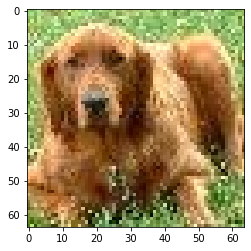

In [13]:
new_image_path = '../dataset/test/n02099601_130.jpeg'
new_img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

## We obtain the images most similar to a new image






In [16]:
new_image_path = list(images_path.values())[random.randrange(0, len(folders)*n_imgs - 1)]
new_img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

# Calculate the color histogram for the new image
new_histogram = calculate_color_histogram(new_img)
histogram_flat = new_histogram.reshape(1, -1)
distance, indices = knn.kneighbors(histogram_flat, n_neighbors=5)

idx_dist = list(zip(indices[0], distance[0]))
idx_dist = [tuples[0] for tuples in sorted(idx_dist, key=lambda x: x[1])]
ids = []
for idx in idx_dist:
        folder = str(int(color_histograms[idx, 0]))
        num_img = str(int(color_histograms[idx, 1]))
        ids.append((folder, num_img))


In [17]:
def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("The value of n must be greater than 0.")
        return

    if n > len(sorted_indexes):
        print(f"There are only {len(sorted_indexes)} images in the list. Displaying all.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        folder_name = (sorted_indexes[i][0])
        img_number = (sorted_indexes[i][1])
        path = images_path[(folder_name, img_number)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        title = f'{folder_name}_{img_number}'
        axs[i].set_title(title)
        
    plt.show()

display_n_similar(ids, 5)
